#  Class assignment - Learning Credit Information

### [Problem 1] Confirmation of competition contents

**1. What to learn and what to predict?**
We learn from a variety of alternative data-- including telco and transactional information.
We should be able to predict Home Credit's clients' repayment abilities with the dataset provided.

**2. What kind of file to create and submit to Kaggle?**
For each SK_ID_CURR in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:
```
SK_ID_CURR,TARGET
100001,0.1
100005,0.9
100013,0.2
etc.
```
**3. What kind of index value will be used to evaluate the submissions?**
`TARGET` will be used to evaluate the submissions.

### [Problem 2] Learning and verification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('application_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Clear value with missing value > 0
df = df.drop(columns=df.columns[df.isnull().sum() > 0])
# Remove the FLAG_DOCUMENT_* columns and SK_ID_CURR (since its represent the ID No. only)
column_save = list(filter(lambda x: not x.startswith('FLAG_DOCUMENT'), df.columns))
df = df[column_save].drop(columns='SK_ID_CURR')
df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,...,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,Higher education,...,1,MONDAY,11,0,0,0,0,0,0,School
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,...,2,MONDAY,9,0,0,0,0,0,0,Government
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,...,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,...,2,THURSDAY,11,0,0,0,0,1,1,Religion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,Cash loans,M,N,N,0,157500.0,254700.0,Working,Secondary / secondary special,...,1,THURSDAY,15,0,0,0,0,0,0,Services
307507,0,Cash loans,F,N,Y,0,72000.0,269550.0,Pensioner,Secondary / secondary special,...,2,MONDAY,8,0,0,0,0,0,0,XNA
307508,0,Cash loans,F,N,Y,0,153000.0,677664.0,Working,Higher education,...,3,THURSDAY,9,0,0,0,0,1,1,School
307509,1,Cash loans,F,N,Y,0,171000.0,370107.0,Commercial associate,Secondary / secondary special,...,2,WEDNESDAY,9,0,0,0,1,1,0,Business Entity Type 1


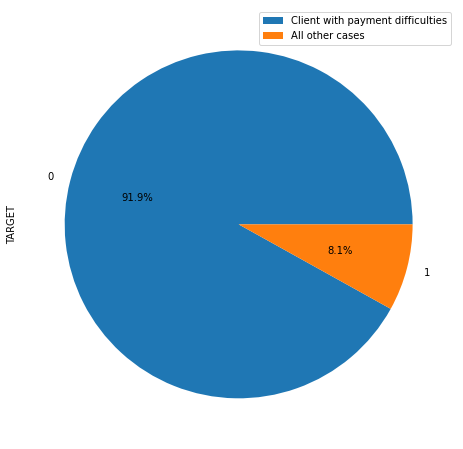

In [4]:
# Plot the target proportion
tg = df["TARGET"].value_counts()
plt.subplots(figsize=(12,8))
pie_target = tg.plot.pie(autopct="%.1f%%")
pie_target.legend(loc=1, labels={'Client with payment difficulties': 0, 'All other cases': 1})
plt.show()

In [5]:
def dummy_variable_all(df, sort_frequence=True, dropna=True, map_show=False, skip_column=[]):
    for column_name in df:
        if np.dtype(df[column_name]) == 'O' and column_name not in skip_column:
            if sort_frequence:
                unique_value = df[column_name].value_counts(dropna=dropna).sort_values().index
            else:
                unique_value = df[column_name].value_counts(dropna=dropna).sort_index().index
            name_map = {}
            for i, value in enumerate(unique_value):
                name_map[value] = i
            if map_show:
                print('column_name :', column_name)
                print('replace :', name_map)
            df[column_name] = df[column_name].map(name_map)
    return df

In [6]:
df2 = dummy_variable_all(df.copy(), dropna=False, map_show=True)
df2.fillna(df2.median(), inplace=True)

column_name : NAME_CONTRACT_TYPE
replace : {'Revolving loans': 0, 'Cash loans': 1}
column_name : CODE_GENDER
replace : {'XNA': 0, 'M': 1, 'F': 2}
column_name : FLAG_OWN_CAR
replace : {'Y': 0, 'N': 1}
column_name : FLAG_OWN_REALTY
replace : {'N': 0, 'Y': 1}
column_name : NAME_INCOME_TYPE
replace : {'Maternity leave': 0, 'Businessman': 1, 'Student': 2, 'Unemployed': 3, 'State servant': 4, 'Pensioner': 5, 'Commercial associate': 6, 'Working': 7}
column_name : NAME_EDUCATION_TYPE
replace : {'Academic degree': 0, 'Lower secondary': 1, 'Incomplete higher': 2, 'Higher education': 3, 'Secondary / secondary special': 4}
column_name : NAME_FAMILY_STATUS
replace : {'Unknown': 0, 'Widow': 1, 'Separated': 2, 'Civil marriage': 3, 'Single / not married': 4, 'Married': 5}
column_name : NAME_HOUSING_TYPE
replace : {'Co-op apartment': 0, 'Office apartment': 1, 'Rented apartment': 2, 'Municipal apartment': 3, 'With parents': 4, 'House / apartment': 5}
column_name : WEEKDAY_APPR_PROCESS_START
replace : {'

In [7]:
pd.set_option('display.max_columns', None)
df2

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE
0,1,1,1,1,1,0,202500.0,406597.5,7,4,4,5,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,2,2,5,10,0,0,0,0,0,0,57
1,0,1,2,1,0,0,270000.0,1293502.5,4,3,5,5,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,1,1,4,11,0,0,0,0,0,0,50
2,0,0,1,0,1,0,67500.0,135000.0,7,4,4,5,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,2,2,4,9,0,0,0,0,0,0,51
3,0,1,2,1,1,0,135000.0,312682.5,7,4,3,5,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2,2,5,17,0,0,0,0,0,0,57
4,0,1,1,1,1,0,121500.0,513000.0,7,4,4,5,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,2,2,3,11,0,0,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,1,1,1,0,0,157500.0,254700.0,7,4,2,4,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1,1,3,15,0,0,0,0,0,0,29
307507,0,1,2,1,1,0,72000.0,269550.0,5,4,1,5,0.025164,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,2,2,4,8,0,0,0,0,0,0,56
307508,0,1,2,1,1,0,153000.0,677664.0,7,3,2,5,0.005002,-14966,-7921,-6737.0,-5150,1,1,0,1,0,1,3,3,3,9,0,0,0,0,1,1,50
307509,1,1,2,1,1,0,171000.0,370107.0,6,4,5,5,0.005313,-11961,-4786,-2562.0,-931,1,1,0,1,0,0,2,2,5,9,0,0,0,1,1,0,46


In [8]:
df2.dtypes.value_counts()

int64      30
float64     4
dtype: int64

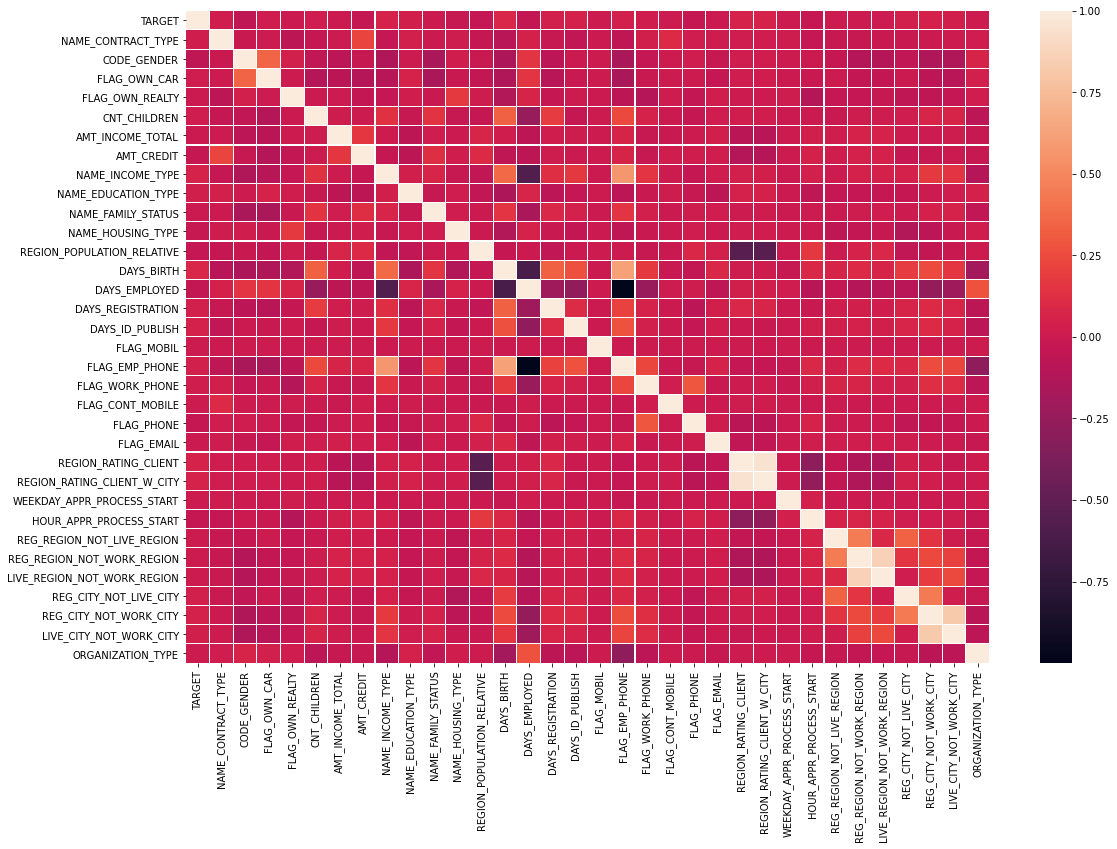

In [9]:
# Get the correlation
corr = df2.corr()

plt.subplots(figsize=(18, 12))
sns.heatmap(corr, linewidth=0.1)
plt.show()

In [10]:
target_corr = abs(corr['TARGET'].copy().drop(index=['TARGET'])).sort_values(ascending=False)
target_corr

DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
NAME_INCOME_TYPE               0.059979
REGION_RATING_CLIENT           0.058899
CODE_GENDER                    0.054692
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
DAYS_REGISTRATION              0.041975
REGION_POPULATION_RELATIVE     0.037227
LIVE_CITY_NOT_WORK_CITY        0.032518
NAME_EDUCATION_TYPE            0.032434
NAME_CONTRACT_TYPE             0.030896
AMT_CREDIT                     0.030369
FLAG_WORK_PHONE                0.028524
HOUR_APPR_PROCESS_START        0.024166
FLAG_PHONE                     0.023806
FLAG_OWN_CAR                   0.021851
CNT_CHILDREN                   0.019187
NAME_HOUSING_TYPE              0.018267
REG_REGION_NOT_WORK_REGION     0.006942
FLAG_OWN_REALTY                0.006148
REG_REGION_NOT_LIVE_REGION     0.005576


In [11]:
# Extract the data
X = df2[df2.columns.copy().drop('TARGET')].values
y = df2['TARGET'].values
print(X.shape)

(307511, 33)


In [12]:
from sklearn.feature_selection import SelectKBest, f_classif
X_new = SelectKBest(f_classif, k=2).fit_transform(X, y)
print(X_new)

[[-9.4610e+03  2.0000e+00]
 [-1.6765e+04  1.0000e+00]
 [-1.9046e+04  2.0000e+00]
 ...
 [-1.4966e+04  3.0000e+00]
 [-1.1961e+04  2.0000e+00]
 [-1.6856e+04  1.0000e+00]]


In [13]:
# Get the name of selected features
selected_features = []
for i in df2.columns:
    if all(df2.loc[:, i] == X_new[:, 0]) or all(df2.loc[:, i] == X_new[:, 1]):
        selected_features.append(i)
print(selected_features)

['DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY']


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, train_size=0.75, test_size=0.25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(230633, 2) (76878, 2) (230633,) (76878,)


In [15]:
# Normalized the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
#Compare before and after scaled
print(X_train)
print(X_train_scaled)
print(X_test)
print(X_test_scaled)

[[-2.3239e+04  2.0000e+00]
 [-2.3447e+04  3.0000e+00]
 [-2.0097e+04  2.0000e+00]
 ...
 [-1.9215e+04  3.0000e+00]
 [-2.2437e+04  2.0000e+00]
 [-1.3712e+04  2.0000e+00]]
[[-1.65017999 -0.06144816]
 [-1.69783397  1.9276009 ]
 [-0.93033003 -0.06144816]
 ...
 [-0.72825885  1.9276009 ]
 [-1.46643726 -0.06144816]
 [ 0.53250955 -0.06144816]]
[[-1.9546e+04  2.0000e+00]
 [-1.8031e+04  2.0000e+00]
 [-8.2600e+03  1.0000e+00]
 ...
 [-1.1393e+04  2.0000e+00]
 [-2.0084e+04  2.0000e+00]
 [-2.3666e+04  2.0000e+00]]
[[-0.80409282 -0.06144816]
 [-0.45699776 -0.06144816]
 [ 1.78159357 -2.05049723]
 ...
 [ 1.06380556 -0.06144816]
 [-0.92735166 -0.06144816]
 [-1.7480081  -0.06144816]]


In [17]:
y_train.shape

(230633,)

In [18]:
#Create function to calculate all scores/evaluations
from sklearn.metrics import *

def evaluation(test, predict):
    acc_score = accuracy_score(test, predict)
    prec_score = precision_score(test, predict)
    rec_score = recall_score(test, predict)
    f_score = f1_score(test, predict)
    conf_matrix = confusion_matrix(test, predict)
    print('Accuracy : {:.3f}'.format(acc_score))
    print('Precision: {:.3f}'.format(prec_score))
    print('Recall   : {:.3f}'.format(rec_score))
    print('F        : {:.3f}'.format(f_score))
    print('Confusion matrix:\n', conf_matrix)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

neigh5 = KNeighborsClassifier()
neigh5.fit(X_train_scaled, y_train)
predict_5 = neigh5.predict(X_test_scaled)
evaluation(y_test, predict_5)

Accuracy : 0.915
Precision: 0.097
Recall   : 0.007
F        : 0.013
Confusion matrix:
 [[70309   402]
 [ 6124    43]]


In [21]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
dt_predict = dt.predict(X_test_scaled)
evaluation(y_test, dt_predict)

Accuracy : 0.911
Precision: 0.087
Recall   : 0.012
F        : 0.020
Confusion matrix:
 [[69962   749]
 [ 6096    71]]


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
rf_predict = rf.predict(X_test_scaled)
evaluation(y_test, rf_predict)

Accuracy : 0.909
Precision: 0.091
Recall   : 0.015
F        : 0.025
Confusion matrix:
 [[69807   904]
 [ 6076    91]]


In [23]:
knn5_prob = neigh5.predict_proba(X_test_scaled)
dt_prob = dt.predict_proba(X_test_scaled)
rf_prob = rf.predict_proba(X_test_scaled)

In [24]:
average_prob = (knn5_prob + dt_prob + rf_prob) / 3
average_prob

array([[1.        , 0.        ],
       [0.86043231, 0.13956769],
       [0.90805556, 0.09194444],
       ...,
       [0.8647093 , 0.1352907 ],
       [0.96534986, 0.03465014],
       [0.90797657, 0.09202343]])

In [25]:
predict_res = 1 - average_prob[:, 0]
predict_res

array([0.        , 0.13956769, 0.09194444, ..., 0.1352907 , 0.03465014,
       0.09202343])

### [Problem 3] Estimation on test data

In [42]:
# Predict with application_train.csv
df_test = pd.read_csv('application_test.csv')
df_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Marr

In [43]:
X_test_file = df_test[selected_features].values

In [44]:
# Normalized the data
X_test_file_scaled = scaler.transform(X_test_file)
X_test_file_scaled

array([[-0.7342156 , -0.06144816],
       [-0.46455824, -0.06144816],
       [-0.9168128 , -0.06144816],
       ...,
       [ 0.02618606, -0.06144816],
       [ 0.47385851, -0.06144816],
       [ 0.47523314, -0.06144816]])

In [48]:
knn5_prob = neigh5.predict_proba(X_test_file_scaled)
dt_prob = dt.predict_proba(X_test_file_scaled)
rf_prob = rf.predict_proba(X_test_file_scaled)
average_prob = (knn5_prob + dt_prob + rf_prob) / 3
predict_res = 1 - average_prob[:, 0]

In [49]:
pred = pd.Series(predict_res, name='TARGET')
final = pd.concat([df_test['SK_ID_CURR'], pred], axis=1)
final

,SK_ID_CURR,TARGET
0,100001,0.128219
1,100005,0.129905
2,100013,0.000000
3,100028,0.191838
4,100038,0.051922
...,...,...
48739,456221,0.000000
48740,456222,0.125295
48741,456223,0.000000
48742,456224,0.078847


In [51]:
import os
final.to_csv(os.path.join('','oof_all_01.csv'), index=False)

### [Problem 4] Feature engineering

**1. Which feature to use?**

We chose `DAYS_BIRTH` and `REGION_RATING_CLIENT_W_CITY` as the feature to use in this assignment. They are chosen by `sklearn.feature_selection` with the scoring function `f_classif` used for classification only.

**2. How to preprocess?**
- Remove the columns with missing value(s) and the columns that represents little in the real world.
- Visualize some statistics from the data.
- Change string value to dummy data.

A Kaggle notebook can be seen [here](https://www.kaggle.com/cherifisimbiaimable/kaggle-exercise).